# Improvement towards the reflexion computation from NoiseModelling 

<br><br>

---
### Imports

In [1]:
import sys
sys.path += [".."] # os.path.abspath("../img-phy-sim")

import img_phy_sim as ips
from img_phy_sim.data import PhysGenDataset, get_image

import os
import random

import numpy as np
import cv2
from torch.utils.data import DataLoader

d:\Programme\Anaconda\envs\img-phy-sim\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


---
### Data Loading

In [2]:
def numpy_info_ORIGINAL(numpy_array, should_print=True):
    result = "Array Statistics:"
    result += f"\n    - mean = {numpy_array.mean():.2f}"
    result += f"\n    - median = {np.median(numpy_array):.2f}"
    # result += f"\n    - percentile = {np.percentile(numpy_array, [25, 50, 75])}"
    result += f"\n    - std = {numpy_array.std():.2f}"
    result += f"\n    - var = {numpy_array.var():.2f}"
    result += f"\n    - min = {numpy_array.min():.2f}"
    result += f"\n    - max = {numpy_array.max():.2f}"
    result += f"\n    - shape = {numpy_array.shape}"
    
    if should_print:
        print(result)
    return result

In [3]:
data_path = "../datasets/physgen_train_raw/osm/"

nm_gt_file = data_path + random.sample(os.listdir(data_path), 1)[0]
# img_src = data_path + "input_physgen_2822.png"
should_scale = True
nm_gt_file

'../datasets/physgen_train_raw/osm/input_physgen_3367.png'

In [4]:
nm_gt = cv2.imread(nm_gt_file, cv2.IMREAD_GRAYSCALE)
nm_gt.shape

(256, 256)

Or:

In [5]:
# img_src = "./cache_img.png"
# ips.img.save(
#     get_image(mode='train', variation="sound_reflection", input_type="osm", output_type="complex_only", 
#               shuffle=True, return_output=False, as_numpy_array=True), 
#     img_src, should_scale=False)
# should_scale = False

# img_src

In [6]:
nm_in, nm_gt = get_image(mode='train', variation="sound_reflection", input_type="osm", output_type="complex_only", 
               shuffle=False, return_output=True, as_numpy_array=True)

nm_in_file = "./cache_img_1_input.png"
ips.img.save(nm_in, nm_in_file, should_scale=False)

nm_gt_file = "./cache_img_1_output.png"
ips.img.save(nm_gt, nm_gt_file, should_scale=False)

PhysGen (sound_reflection) Dataset for train got created


In [7]:
ips.math.numpy_info(nm_gt);

Array Statistics:
    - mean = 0.05
    - median = 0.00
    - std = 0.10
    - var = 0.01
    - min = -0.00
    - max = 0.46
    - shape = (256, 256)


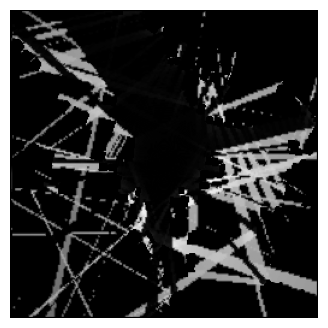

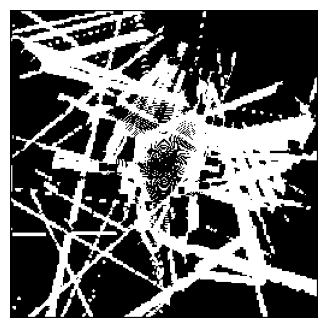

In [8]:
ips.img.imshow(nm_gt, size=4)

nm_gt_test = nm_gt / 255
nm_gt_test = nm_gt_test != 0.0

ips.img.imshow(nm_gt_test, size=4)

---
### Error Measurement Definition

In [9]:
def calc_metrices_ORIGINAL(rays, noise_modelling_gt, rays_format_is_image=False, eval_name="", should_print=True):
    # Create image from rays
    if rays_format_is_image:
        ray_img = rays
    else:
        ray_img = ips.ray_tracing.draw_rays(rays, detail_draw=True, 
                                            output_format="single_image", 
                                            img_background=None, ray_value=1.0, ray_thickness=1, 
                                            img_shape=(256, 256), dtype=float, standard_value=0,
                                            should_scale_rays_to_image=True, original_max_width=None, original_max_height=None)
    
    # Normalize both (if needed)
    if (noise_modelling_gt > 1.0).any():
        # raise ValueError("Noise Modelling Ground Truth Image is not normalized.")
        noise_modelling_gt /= 255

    if (ray_img > 1.0).any():
        # raise ValueError("Ray Image is not normalized.")
        ray_img /= 255

    # Thresholding to binary images
    noise_modelling_gt_binary = noise_modelling_gt != 0.0
    # numpy_info(noise_modelling_gt_binary)
    rays_binary = ray_img != 0.0

    # Recall, Precision, F1 Score
    overlap = noise_modelling_gt_binary * rays_binary

    #     recall - how is the coverage towards the gt?
    recall = np.sum(overlap) / np.sum(noise_modelling_gt_binary)

    #     precision - how many rays hit the right place?
    precision = np.sum(overlap) / np.sum(rays_binary)

    #     f1
    f1 = 2*(precision*recall) / (precision+recall)

    if should_print:
        print(f"Eval {eval_name}: F1={f1:.02f}, Recall={recall:.02f}, Precision={precision:.02f}")
    return f1, recall, precision

---
### Error Measurement Testing

In [10]:
rays = ips.ray_tracing.trace_beams(rel_position=[0.5, 0.5], 
                                   img_src=nm_in, 
                                   directions_in_degree=ips.math.get_linear_degree_range(start=0, stop=360, step_size=10),
                                   wall_values=None, 
                                   wall_thickness=0,
                                   img_border_also_collide=False,
                                   reflexion_order=3,
                                   should_scale_rays=True,
                                   should_scale_img=False)
ips.ray_tracing.print_rays_info(rays)

d:\Programme\Anaconda\envs\img-phy-sim\Lib\site-packages\numpy\_core\numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Rays: 36
Beams: 135
    - Mean Beams per Ray: 3.8
        - Median: 4.0
        - Max: 4
        - Min: 1
        - Variance: 0.8
Reflexions: 99
    - Mean Reflexions per Ray: 2.8
        - Median: 3.0
        - Max: 3
        - Min: 0
        - Variance: 0.8
Points: 4910
    - Mean Points per Beam: 36.4
        - Median: 2.0
        - Max: 204
        - Min: 2
        - Variance: 54.6
    - Mean Point Values: 2.0
        - Median: 2.0
        - Variance: 0.0

Value-Range:
  x ∈ [0.11, 0.98]
  y ∈ [-0.00, 0.90]

Example:
Ray 1, beams: 4
Ray 1, beam 1, points: 42
Ray 1, beam 1, point 1: 2




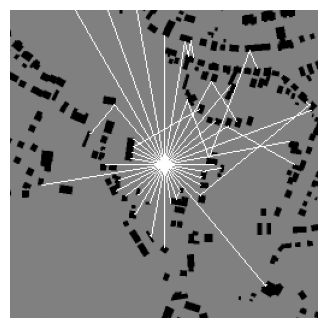

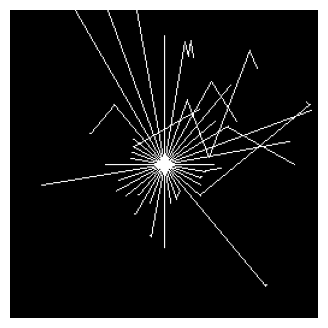

In [11]:
ray_img = ips.ray_tracing.draw_rays(rays, detail_draw=False, 
                                    output_format="single_image", 
                                    img_background=nm_in, ray_value=2, ray_thickness=1, 
                                    img_shape=(256, 256), dtype=float, standard_value=0,
                                    should_scale_rays_to_image=True, original_max_width=None, original_max_height=None)
ips.img.imshow(ray_img, size=4)

ray_img = ips.ray_tracing.draw_rays(rays, detail_draw=False, 
                                    output_format="single_image", 
                                    img_background=None, ray_value=1, ray_thickness=1, 
                                    img_shape=(256, 256), dtype=float, standard_value=0,
                                    should_scale_rays_to_image=True, original_max_width=None, original_max_height=None)
ips.img.imshow(ray_img!=0.0, size=4)

In [12]:
f1, recall, precision = ips.eval.calc_metrices(rays, nm_gt)

Eval : F1=0.12, Recall=0.07, Precision=0.56


In [13]:
f1, recall, precision = ips.eval.calc_metrices(nm_gt, nm_gt, rays_format_is_image=True)

Eval : F1=1.00, Recall=1.00, Precision=1.00


---
### Helper

In [32]:
def evaluate_mean_physgen(compute_func, rays_format_is_image=True, ground_truth_pass=False, one_right_guess=False):
    dataset = PhysGenDataset(mode='test', variation="sound_reflection", input_type="osm", output_type="complex_only")

    f1_mean = 0
    recall_mean = 0
    precision_mean = 0
    counter = 0
    for (input_img, target_img, idx) in dataset:
        input_img = input_img.squeeze(0).numpy()
        target_img = target_img.squeeze(0).numpy()
        if ground_truth_pass:
            rays = target_img
            rays_format_is_image = True
        else:
            rays = compute_func(input_img)

        if one_right_guess:
            idx = np.argwhere(target_img > 0.1)[0]
            rays[idx[0]][idx[1]] = 1

        f1, recall, precision = ips.eval.calc_metrices(rays, target_img, rays_format_is_image=rays_format_is_image, should_print=False)
        f1_mean += f1
        recall_mean += recall
        precision_mean += precision
        counter += 1

    f1_mean /= counter
    recall_mean /= counter
    precision_mean /= counter

    print(f"Baseline Accuracy: F1={f1_mean:.2f}, Recall={recall_mean:.02f}, Precision={precision_mean:.02f}")
    return f1_mean, recall_mean, precision_mean

---
### Ray-Amount Test

In [15]:
for i in [100, 10, 1, 0.1]:
    rays = ips.ray_tracing.trace_beams(rel_position=[0.5, 0.5], 
                                        img_src=nm_in, 
                                        directions_in_degree=ips.math.get_linear_degree_range(start=0, stop=360, step_size=i),
                                        wall_values=None, 
                                        wall_thickness=0,
                                        img_border_also_collide=False,
                                        reflexion_order=3,
                                        should_scale_rays=True,
                                        should_scale_img=False)
    f1, recall, precision = ips.eval.calc_metrices(rays, nm_gt, eval_name=f"{len(ips.math.get_linear_degree_range(start=0, stop=360, step_size=i))} Rays")

f1, recall, precision = ips.eval.calc_metrices(nm_gt, nm_gt, rays_format_is_image=True, eval_name="Ground Truth")

Eval 4 Rays: F1=0.01, Recall=0.01, Precision=0.48
Eval 36 Rays: F1=0.12, Recall=0.07, Precision=0.56
Eval 360 Rays: F1=0.51, Recall=0.45, Precision=0.58
Eval 3600 Rays: F1=0.58, Recall=0.63, Precision=0.54
Eval Ground Truth: F1=1.00, Recall=1.00, Precision=1.00


---
### Ground Truth

In [16]:
evaluate_mean_physgen(None, rays_format_is_image=True, ground_truth_pass=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=1.00, Recall=1.00, Precision=1.00


(np.float64(1.0), np.float64(1.0), np.float64(1.0))

---
### Random

In [17]:
def random_map(input_img):
    return np.random.default_rng().integers(low=0, high=2, size=input_img.shape)
    
evaluate_mean_physgen(random_map, rays_format_is_image=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.41, Recall=0.50, Precision=0.35


(np.float64(0.41000709725876955),
 np.float64(0.5001387215114925),
 np.float64(0.3549209518985062))

---
### Only Negatives/Positives

-> but one True positive

In [33]:
def negative_map(input_img):
    negatives = np.full(shape=input_img.shape, fill_value=0, dtype=np.uint8)
    # negatives[0][0] = 1  # to make divisions possible
    return negatives
    
evaluate_mean_physgen(negative_map, rays_format_is_image=True, one_right_guess=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.00, Recall=0.00, Precision=1.00


(np.float64(9.132684409998034e-05),
 np.float64(4.5665677271188524e-05),
 np.float64(1.0))

In [19]:
def positive_map(input_img):
    return np.ones(shape=input_img.shape, dtype=np.uint8)
    
evaluate_mean_physgen(positive_map, rays_format_is_image=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.52, Recall=1.00, Precision=0.35


(np.float64(0.5187413654533285),
 np.float64(1.0),
 np.float64(0.35487089739735106))

---
### Baseline (Classical Ray-Tracing)

All experiments are based now on 36 rays.

In [20]:
def ray_tracing(input_img):
    return ips.ray_tracing.trace_beams(rel_position=[0.5, 0.5], 
                                        img_src=input_img, 
                                        directions_in_degree=ips.math.get_linear_degree_range(start=0, stop=360, step_size=36),
                                        wall_values=None, 
                                        wall_thickness=0,
                                        img_border_also_collide=False,
                                        reflexion_order=3,
                                        should_scale_rays=True,
                                        should_scale_img=False)
    
evaluate_mean_physgen(ray_tracing, rays_format_is_image=False)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.05, Recall=0.03, Precision=0.46


(np.float64(0.04898460982151374),
 np.float64(0.025953784493431498),
 np.float64(0.46432484825215353))

---
### ISM

In [21]:
def ism(input_img):
    reflection_map = ips.ism.compute_reflection_map(
        source_rel=(0.5, 0.5),
        img=input_img,
        wall_values=[0],   
        wall_thickness=1,
        max_order=1,
        step_px=1,
        approx_epsilon=0.5,
        ignore_ends=1
    )
    return ips.ism.reflection_map_to_img(reflection_map)
    

evaluate_mean_physgen(ism, rays_format_is_image=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.62, Recall=0.90, Precision=0.50


(np.float64(0.6249466537217802),
 np.float64(0.8972038268252072),
 np.float64(0.49689269359640575))

In [22]:
def ism_zero_grad(input_img):
    reflection_map = ips.ism.compute_reflection_map(
        source_rel=(0.5, 0.5),
        img=input_img,
        wall_values=[0],   
        wall_thickness=1,
        max_order=1,
        step_px=1,
        approx_epsilon=0.5,
        ignore_ends=1,
        ignore_zero_order=True
    ) 
    return ips.ism.reflection_map_to_img(reflection_map)
    


evaluate_mean_physgen(ism_zero_grad, rays_format_is_image=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.58, Recall=0.61, Precision=0.56


(np.float64(0.5779005459839919),
 np.float64(0.6063111202530886),
 np.float64(0.5578291592992605))

In [23]:
def ism_zero_grad_ignore_ends_zero(input_img):
    reflection_map = ips.ism.compute_reflection_map(
        source_rel=(0.5, 0.5),
        img=input_img,
        wall_values=[0],   
        wall_thickness=1,
        max_order=1,
        step_px=1,
        approx_epsilon=0.5,
        ignore_ends=0,
        ignore_zero_order=True
    ) 
    return ips.ism.reflection_map_to_img(reflection_map)
    


evaluate_mean_physgen(ism_zero_grad_ignore_ends_zero, rays_format_is_image=True)

PhysGen (sound_reflection) Dataset for test got created
Baseline Accuracy: F1=0.45, Recall=0.37, Precision=0.58


(np.float64(0.44511825046493775),
 np.float64(0.37482000349192235),
 np.float64(0.5750090031038844))